In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio, display, HTML

# Add project root directory to Python path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data.dataset import LibriSpeechDataset

# Matplotlib settings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


/Users/yoonjae/miniconda3/envs/11785/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Dataset

Check for tokenizer and CMVN statistics files, then load the test dataset.


In [4]:
# Change to project root directory (since notebook is in 'test' folder)
os.chdir('..')
print(f"Current working directory: {os.getcwd()}")

# Set file paths (now relative to project root)
tokenizer_path = "src/data/tokenizer.model"
cmvn_stats_path = "src/data/cmvn_stats.pt"

# Check if required files exist
if not os.path.exists(tokenizer_path):
    print(f"❌ Tokenizer not found: {tokenizer_path}")
    print("Please run 'python main.py' first to generate the tokenizer.")
elif not os.path.exists(cmvn_stats_path):
    print(f"❌ CMVN statistics not found: {cmvn_stats_path}")
    print("Please run 'python main.py' first to compute CMVN statistics.")
else:
    print("✓ Required files found")
    
    # Load CMVN statistics
    cmvn_stats = torch.load(cmvn_stats_path)
    
    # Load test dataset
    print("\nLoading dataset...")
    test_dataset = LibriSpeechDataset(
        split='test',
        tokenizer_path=tokenizer_path,
        cmvn_stats=cmvn_stats,
        apply_spec_augment=False,  # Disable augmentation for visualization
    )
    
    print(f"✓ Test dataset loaded successfully: {len(test_dataset)} samples")


Current working directory: /Users/yoonjae/github/CMU-11785-IDL-1.58bit-ASR
✓ Required files found

Loading dataset...
Loading test data from data...
  Loading test.clean from data/test.clean_subset...
    Loaded 262 samples
  Loading test.other from data/test.other_subset...
    Loaded 293 samples
  Total samples after combining: 555
✓ Test dataset loaded successfully: 555 samples


/Users/yoonjae/miniconda3/envs/11785/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


## 3. Fetch Sample Data

Select a sample index to load and inspect the data.


In [5]:
# Select sample index (from 0 to len(test_dataset)-1)
SAMPLE_INDEX = 42  # Change to any desired index

# Fetch sample
sample = test_dataset[SAMPLE_INDEX]
raw_data = test_dataset.dataset[SAMPLE_INDEX]

# Extract data
fbank = sample['fbank']  # FBank features (Time, Freq)
labels = sample['labels']  # Tokenized labels
audio_array = raw_data['audio']['array']  # Raw audio waveform
sampling_rate = raw_data['audio']['sampling_rate']  # Sampling rate

# Decode text using tokenizer
tokenizer = test_dataset.tokenizer
transcription = tokenizer.decode(labels.tolist())

print(f"Sample #{SAMPLE_INDEX} Information:")
print(f"  - Audio duration: {len(audio_array) / sampling_rate:.2f} seconds")
print(f"  - Sampling rate: {sampling_rate} Hz")
print(f"  - FBank shape: {fbank.shape} (time frames, frequency bins)")
print(f"  - Number of tokens: {len(labels)}")
print(f"  - Transcription: '{transcription}'")


Sample #42 Information:
  - Audio duration: 7.36 seconds
  - Sampling rate: 16000 Hz
  - FBank shape: torch.Size([734, 80]) (time frames, frequency bins)
  - Number of tokens: 27
  - Transcription: 'SURFACE DUST AT LEAST HAD BEEN REMOVED AND THE FINE OLD FURNITURE GAVE A HINT OF ITS REAL ELEGANCE AND POLISH'


## 4. 🔊 Audio Playback

Use the player below to listen to the original audio.


In [6]:
# Play audio
print(f"🔊 Audio Playback (Sample #{SAMPLE_INDEX}):")
display(Audio(audio_array, rate=sampling_rate))

🔊 Audio Playback (Sample #42):


## 5. 📊 Spectrogram Visualization

Visualize FBank features to examine the frequency components of the speech signal.


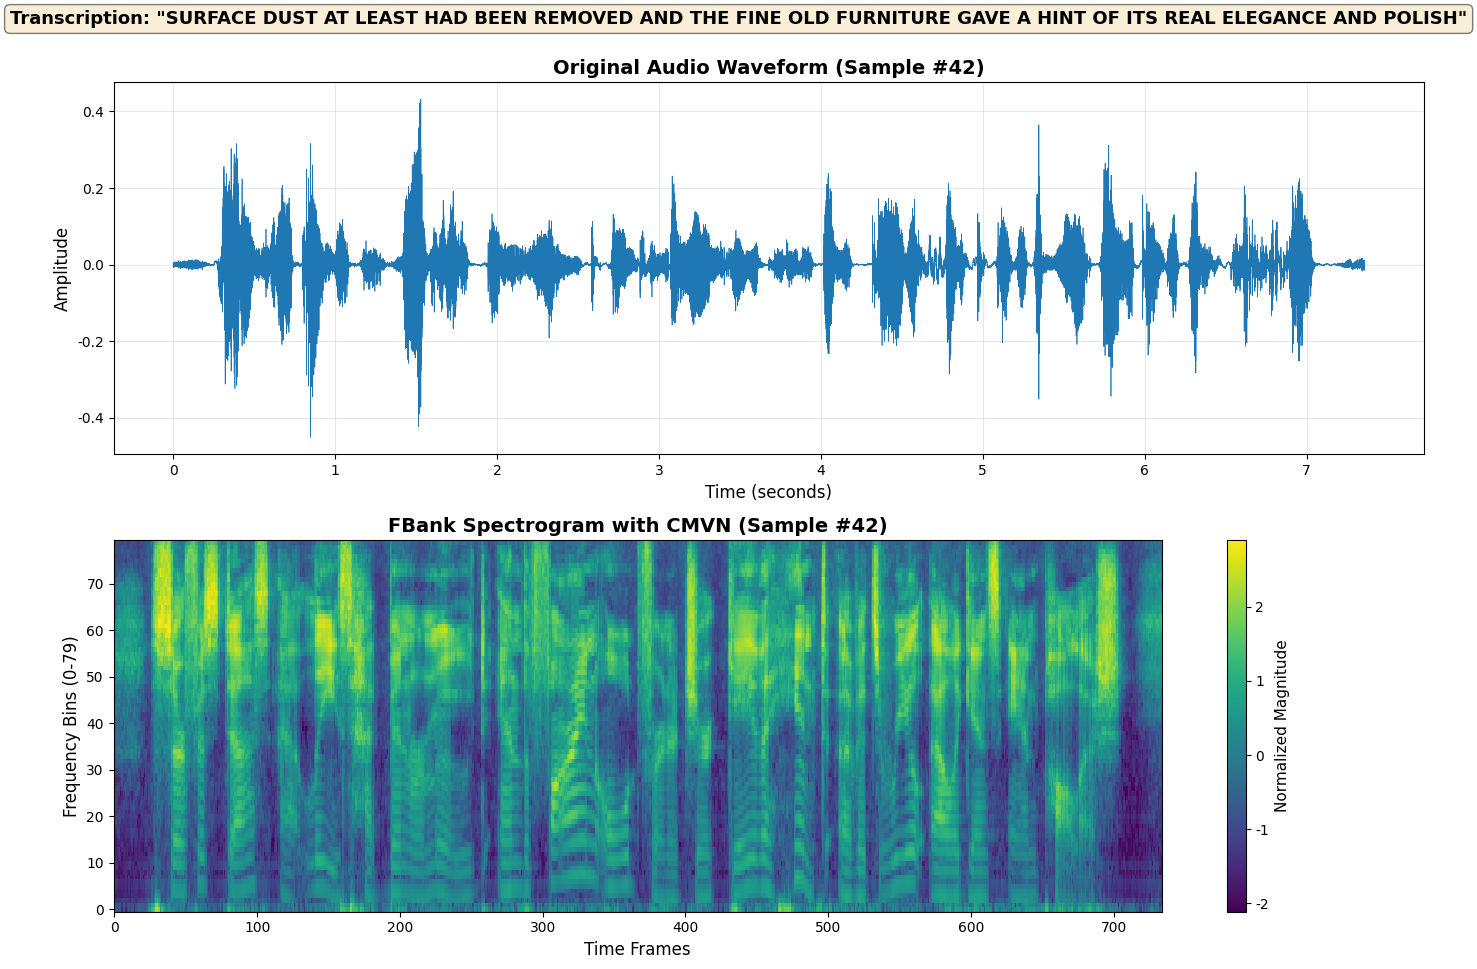


✓ Spectrogram visualization completed


In [7]:
# Visualize spectrogram
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. Original audio waveform
axes[0].plot(np.arange(len(audio_array)) / sampling_rate, audio_array, linewidth=0.5)
axes[0].set_title(f'Original Audio Waveform (Sample #{SAMPLE_INDEX})', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (seconds)', fontsize=12)
axes[0].set_ylabel('Amplitude', fontsize=12)
axes[0].grid(True, alpha=0.3)

# 2. FBank spectrogram (with CMVN normalization applied)
im = axes[1].imshow(
    fbank.T.numpy(),  # Transpose: (Freq, Time)
    aspect='auto',
    origin='lower',
    cmap='viridis',
    interpolation='nearest'
)
axes[1].set_title(f'FBank Spectrogram with CMVN (Sample #{SAMPLE_INDEX})', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Frames', fontsize=12)
axes[1].set_ylabel('Frequency Bins (0-79)', fontsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label('Normalized Magnitude', fontsize=11)

# Display transcription text at the top
fig.text(0.5, 0.95, f'Transcription: "{transcription}"', 
         ha='center', fontsize=13, fontweight='bold', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

print(f"\n✓ Spectrogram visualization completed")


## 6. 📈 FBank Feature Statistics

Analyze statistical properties of FBank features.


FBank Feature Statistics:
  - Shape: (734, 80)
  - Min: -2.1109
  - Max: 2.8984
  - Mean: 0.1625
  - Std: 0.9031
  - Median: 0.1534


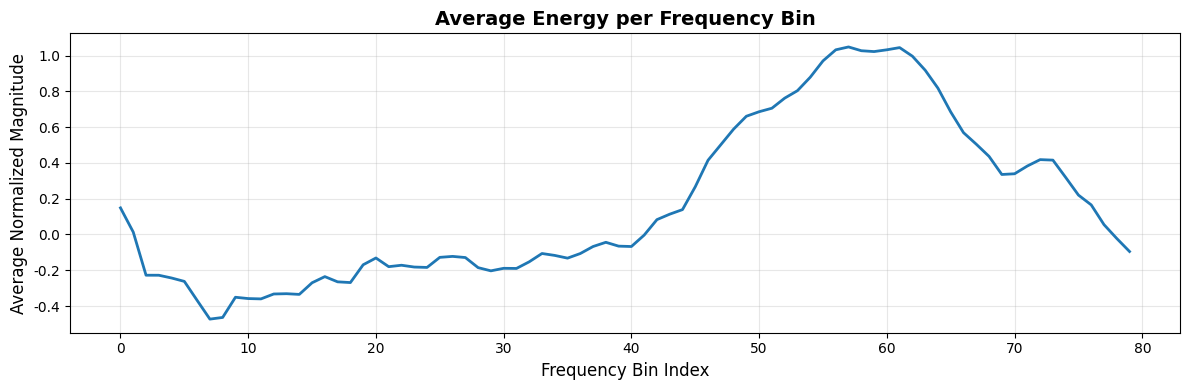


✓ Statistical analysis completed


In [8]:
# FBank statistics
fbank_np = fbank.numpy()

print("FBank Feature Statistics:")
print(f"  - Shape: {fbank_np.shape}")
print(f"  - Min: {fbank_np.min():.4f}")
print(f"  - Max: {fbank_np.max():.4f}")
print(f"  - Mean: {fbank_np.mean():.4f}")
print(f"  - Std: {fbank_np.std():.4f}")
print(f"  - Median: {np.median(fbank_np):.4f}")

# Visualize average energy per frequency bin
freq_means = fbank_np.mean(axis=0)  # Average across time for each frequency bin

plt.figure(figsize=(12, 4))
plt.plot(freq_means, linewidth=2)
plt.title('Average Energy per Frequency Bin', fontsize=14, fontweight='bold')
plt.xlabel('Frequency Bin Index', fontsize=12)
plt.ylabel('Average Normalized Magnitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Statistical analysis completed")


## 7. 📝 Text Transcription Details

Examine tokenized labels and decoded text in detail.


In [9]:
# Display text information
print("=" * 80)
print("Text Transcription Details")
print("=" * 80)
print(f"\nOriginal Text:")
print(f"  {raw_data['text']}")
print(f"\nNormalized Text (Uppercase):")
print(f"  {transcription}")
print(f"\nToken IDs:")
print(f"  {labels.tolist()}")
print(f"\nNumber of tokens: {len(labels)}")
print(f"Text length: {len(transcription)} characters")
print(f"Word count: {len(transcription.split())} words")
print("=" * 80)


Text Transcription Details

Original Text:
  SURFACE DUST AT LEAST HAD BEEN REMOVED AND THE FINE OLD FURNITURE GAVE A HINT OF ITS REAL ELEGANCE AND POLISH

Normalized Text (Uppercase):
  SURFACE DUST AT LEAST HAD BEEN REMOVED AND THE FINE OLD FURNITURE GAVE A HINT OF ITS REAL ELEGANCE AND POLISH

Token IDs:
  [2560, 2878, 101, 1196, 97, 220, 3575, 25, 7, 1330, 371, 2397, 42, 253, 804, 6, 15, 699, 26, 367, 928, 901, 4989, 275, 25, 962, 332]

Number of tokens: 27
Text length: 109 characters
Word count: 21 words


## 8. 🔄 Explore Other Samples

To view different samples, use the function below with the desired index.


In [10]:
def visualize_sample(sample_idx):
    """
    Visualize audio, spectrogram, and text for a specific sample.
    
    Args:
        sample_idx (int): Index of the sample to visualize
    """
    if sample_idx >= len(test_dataset) or sample_idx < 0:
        print(f"❌ Invalid index. Please enter a value between 0 and {len(test_dataset)-1}.")
        return
    
    # Fetch sample
    sample = test_dataset[sample_idx]
    raw_data = test_dataset.dataset[sample_idx]
    
    fbank = sample['fbank']
    labels = sample['labels']
    audio_array = raw_data['audio']['array']
    sampling_rate = raw_data['audio']['sampling_rate']
    
    tokenizer = test_dataset.tokenizer
    transcription = tokenizer.decode(labels.tolist())
    
    # Display information
    print(f"\n{'='*80}")
    print(f"Sample #{sample_idx} Information")
    print(f"{'='*80}")
    print(f"Audio duration: {len(audio_array) / sampling_rate:.2f} seconds")
    print(f"FBank shape: {fbank.shape}")
    print(f"Transcription: '{transcription}'")
    print(f"{'='*80}\n")
    
    # Play audio
    print("🔊 Audio Playback:")
    display(Audio(audio_array, rate=sampling_rate))
    
    # Visualize spectrogram
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Waveform
    axes[0].plot(np.arange(len(audio_array)) / sampling_rate, audio_array, linewidth=0.5)
    axes[0].set_title(f'Audio Waveform (Sample #{sample_idx})', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time (seconds)', fontsize=12)
    axes[0].set_ylabel('Amplitude', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Spectrogram
    im = axes[1].imshow(fbank.T.numpy(), aspect='auto', origin='lower', 
                         cmap='viridis', interpolation='nearest')
    axes[1].set_title(f'FBank Spectrogram (Sample #{sample_idx})', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time Frames', fontsize=12)
    axes[1].set_ylabel('Frequency Bins', fontsize=12)
    
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Normalized Magnitude', fontsize=11)
    
    fig.text(0.5, 0.95, f'Transcription: "{transcription}"', 
             ha='center', fontsize=13, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Usage examples:
# visualize_sample(0)   # First sample
# visualize_sample(100) # 100th sample
# visualize_sample(500) # 500th sample

print("✓ visualize_sample() function is ready.")
print(f"Usage: visualize_sample(index)  (0 ~ {len(test_dataset)-1})")


✓ visualize_sample() function is ready.
Usage: visualize_sample(index)  (0 ~ 554)


### Example: Visualize Another Sample

Run the cell below to explore different samples!



Sample #0 Information
Audio duration: 3.50 seconds
FBank shape: torch.Size([349, 80])
Transcription: 'CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS'

🔊 Audio Playback:


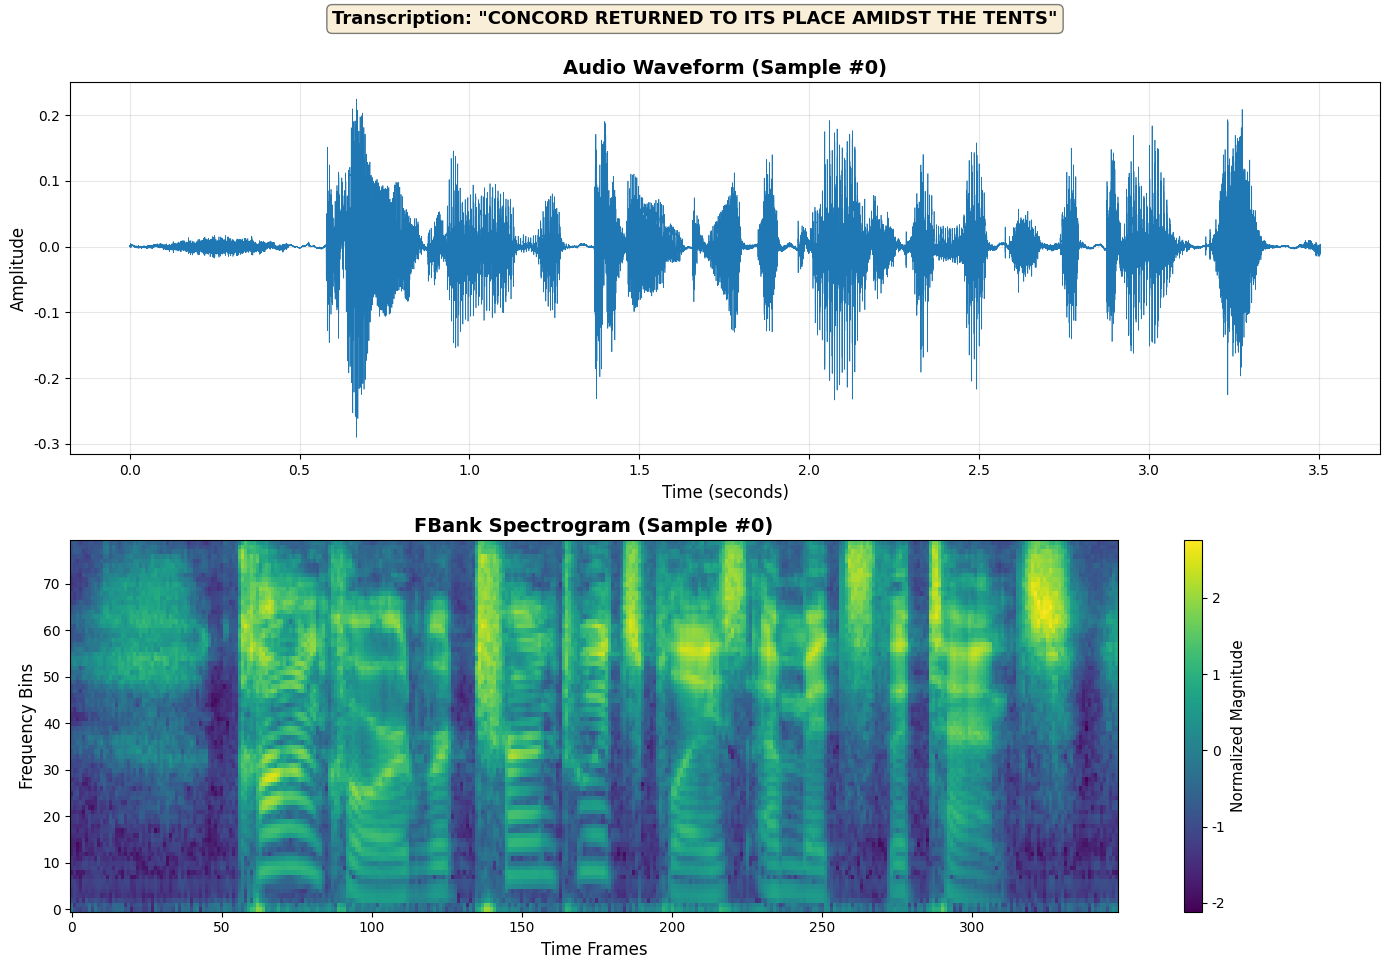

In [11]:
# Visualize a different sample (change the index as desired)
visualize_sample(0)
